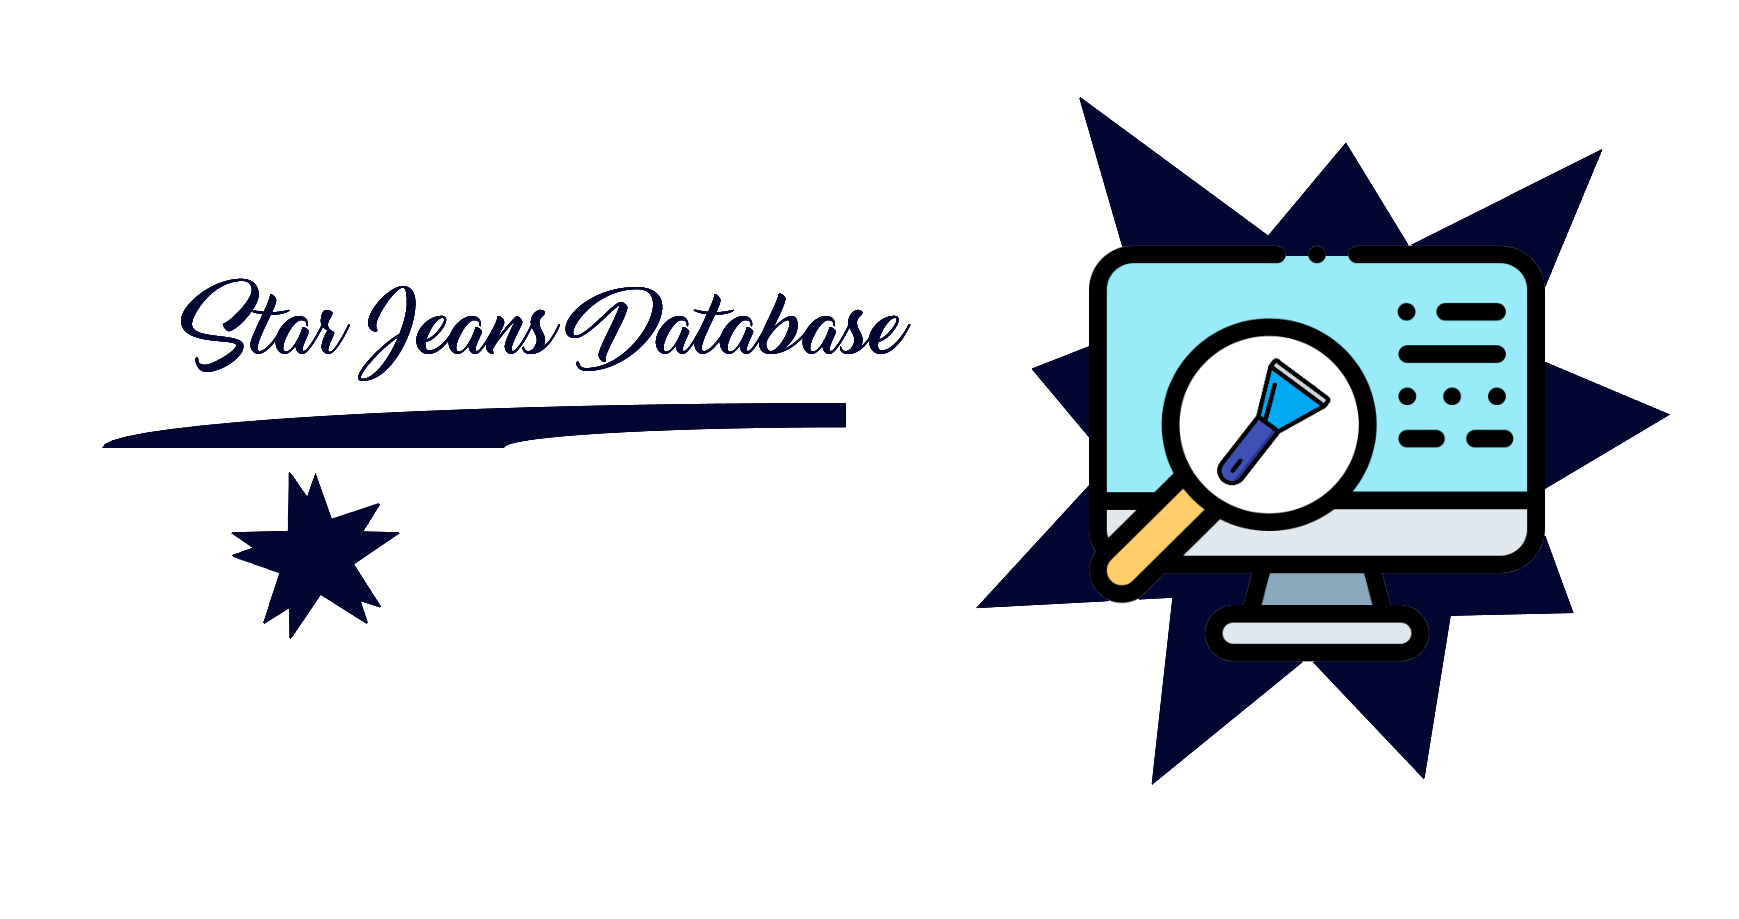

In [3]:
Image('../img/star2.png')

<p style='text-align: center'><i>Star Jeans é uma empresa fictícia que foi utilizada para case de estudos, onde dois empreendedores chamados Eduardo e Marcelo são brasileiros e amigos de empreendimento que estão começando na área de varejo de moda dos EUA depois de vários negócios bem sucedidos.
A ideia inicial é entrar no mercado com um produto específico que é calça jeans para o publico masculino, porém mesmo com o publico bem definido, eles não têm experiência no mercado de varejo de moda, então contrataram uma consultoria de dados para responder algumas perguntas.<i></p>

**Problema de Negócio**
1.	Qual é o Melhor preço de venda para as calças?
2.	Quantos tipos de calças e suas cores para o produto inicial?
3.	Qual a matéria prima necessária para confeccionar essas peças?

**O que é um Varejo?**<br>
É um tipo de modelo de negócio onde o produto é vendido diretamente para o consumidor, como exemplo um mercado, é um Varejo, onde ele vende produtos conforme a demanda e em pequenas quantidades diretamente ao consumidor, onde o dinheiro vem principalmente da qualidade do serviço presencial no atendimento, exposição dos produtos, qualidade da infraestrutura, entre outras.

**O que é um E-Commerce?**<br>
É um modelo de negócio parecido com o varejo vamos dizer assim, onde eu tenho um website que vende produtos online, nesse estrilo de modelo de negócio, o consumidor entra em um processo de afunilamento, quando o consumidor ele conhece a marca, cadastra-se no site, faz o pedido e compra se tornando um cliente. Nesse processo não há funcionários ou a infraestrutura da loja física não existe, pois as vendas são feitas automaticamente no Website. Logo é necessário tem um bom website, com cores que condizem com a marca, qualidade no atendimento online, ou em outras palavras, o dinheiro vem com a experiência e o processo de compra.


**Solução Proposta**
1. Uma base de dados com a Mediana dos preços dos concorrentes por tipo e cor nos próximos 30 dias.
2. Essa Médiana vai estar disponível em uma aplicação na Web.

**Passos Realizados**
1. Coleta dos Dados da H&M da sessão Jeans Masculino.
2. Tratamento dos Dados coletados.
3. Preparação dos Dados já limpos.
4. Armazenamento em um Banco de Dados SQLite.
5. Armazenamento da última preparação realizada em um CSV para Backup.
6. Arquitetura de ETL para automaticamente as 12 Hrs realizar todos os passos anteriores.
7. Desenvolvimento da Aplicação WEB.

## 0.1. Imports

In [47]:
import re
import sqlite3
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from sqlalchemy import create_engine

# 1.0. Complete Web Scraping New Version

## 1.1. Collect Showroom products (Without Pagination)

In [12]:
# Parameters
url = 'https://www2.hm.com/en_us/men/products/jeans.html'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5),AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
page = requests.get( url, headers=headers )
soup = BeautifulSoup( page.text, 'html.parser' )

# ============ product data =========
products = soup.find( 'ul', class_='products-listing small' )

products_list = products.find_all( 'article', class_='hm-product-item' )
p_code = [p.get('data-articlecode') for p in products_list]
p_type = [p.get('data-category') for p in products_list]

products_list = products.find_all( 'a', class_='link' )
p_name = [p.get_text() for p in products_list]

products_list = products.find_all( 'span', class_='price regular' )
p_price = [p.get_text() for p in products_list]
p_price = [float(p.replace('$ ', '')) for p in p_price]

data = pd.DataFrame([p_code, p_name, p_type, p_price]).T
data.columns = ['code', 'name', 'category', 'price']

In [15]:
data['date'] = datetime.now().strftime("%Y-%m-%d")
data.to_csv('../h&m_datasets/h&m_' + data['date'][0])

## 1.2. Colors Collect

In [4]:
for k in data.code.tolist():
    url = 'https://www2.hm.com/en_us/productpage.' + k + '.html'
    #print(url)
    page = requests.get( url, headers=headers )
    soup = BeautifulSoup( page.text, 'html.parser' )

    # Color
    products_list = soup.find_all( 'a', class_='filter-option miniature' ) + soup.find_all( 'a', class_='filter-option miniature active' )
    p_colors = [p.get( 'data-color' ) for p in products_list]

    # Product Id
    p_articlecode = [p.get( 'data-articlecode' ) for p in products_list]

    df_color = pd.DataFrame( [p_articlecode, p_colors] ).T
    df_color.columns = ['Art. No.', 'color']

## 1.3. Showroom Products + Individual Colors

In [8]:
df1 = pd.DataFrame()

for ic in data.code.tolist(): # Colors Collect
    url = 'https://www2.hm.com/en_us/productpage.'+ ic +'.html'
    page = requests.get( url, headers=headers )
    soup = BeautifulSoup( page.text, 'html.parser' )

    # Color
    products_list = soup.find_all( 'a', class_='filter-option miniature' ) + soup.find_all( 'a', class_='filter-option miniature active' )
    p_colors = [p.get( 'data-color' ) for p in products_list]

    # Product Id
    p_articlecode = [p.get( 'data-articlecode' ) for p in products_list]

    df_color = pd.DataFrame( [p_articlecode, p_colors] ).T
    df_color.columns = ['Art. No.', 'color']
    
    for ip in range( len( df_color ) ): # Individual Product Colors Dataset
        url = 'https://www2.hm.com/en_us/productpage.' + df_color['Art. No.'][ip] + '.html'
        page = requests.get( url, headers=headers )
        
        soup = BeautifulSoup( page.text, 'html.parser' ) # HTML With Soup
        p = [list(filter(None, x.get_text().split('\n'))) for x in soup.find_all('div','details-attributes-list-item')]
        price = [float(p.get_text().strip().replace('$', '')) for p in soup.find_all('span', 'price-value')]
        p = p+[['Price', price[0]]]
        df = pd.DataFrame( p ).T
        df.columns = df.iloc[0, :]
        df = df.iloc[1:, :]

        if not 'Care instructions' in df.columns.tolist():
            pass

        else:
            df = df.drop( columns=['Care instructions'], axis=1 )

            df = df.drop_duplicates()

            df1 = pd.concat( [df1, df], axis=0 )

In [13]:
df1.head(2)

,messages.garmentLength,messages.waistRise,Fit,Composition,More sustainable materials,Material,Description,Imported,Concept,Nice to know,Art. No.,Price,messages.clothingStyle,Size
1,Long,Regular waist,Skinny fit,Pocket lining: Cotton 100%,Recycled cotton 20%,Denim,Denim blue,Yes,DENIM,environmentalMarker,0985159002,19.99,NaN,NaN
2,None,None,None,"Shell: Cotton 99%, Spandex 1%",None,None,Solid-color,None,None,None,None,None,NaN,NaN


## 1.4. Data Cleaning & Preparation

### 1.4.1. First Cleaning

In [27]:
df2 = df1.copy() # Data Backup

In [28]:
df2 = df2.drop_duplicates()

df2 = df2.iloc[:, 2:]

if 'Size' in df2.columns:
    df2 = df2.drop( columns=['Material', 'Imported', 'Concept', 'Nice to know', 'messages.clothingStyle', 'More sustainable materials', 'Size'], axis=1 )

else:
    df2 = df2.drop( columns=['Material', 'Imported', 'Concept', 'Nice to know', 'messages.clothingStyle', 'More sustainable materials'], axis=1 )

dfx = df2.iloc[3:, :]
a = df2.iloc[:2, :]
df2 = pd.concat( [dfx, a], axis=0 )

df2.columns = ['fit', 'composition', 'color', 'product_id', 'price']

df2 = df2.fillna( method='ffill' )

df2 = df2[~df2['color'].str.contains('Solid-')]

df2 = df2.reset_index( drop=True )

df2.fit = [f.lower().replace(' ', '_') for f in df2.fit]
df2.color = [f.lower().replace(' ', '_') for f in df2.color]

for j in ['Pocket lining: ', 'Shell: ', 'Lining: ', 'Pocket: ']:
    df2.composition = [ic.strip() for ic in df2.composition.str.replace(j, '')]

In [32]:
df2.head(2)

,fit,composition,color,product_id,price
0,skinny_fit,"Polyester 63%, Cotton 37%",dark_gray,0985159003,11.99
1,skinny_fit,"Cotton 99%, Spandex 1%",light_denim_blue,0985159004,19.99


### 1.4.2. Composition Cleaning

In [33]:
df_ref = pd.DataFrame( index=range( len( df2 ) ), columns=['cotton_', 'polyester_', 'spandex_', 'elasterell_'] )

df3 = df2.composition.str.split(',', expand=True).reset_index(drop=True)

df_cot0 = df3.loc[df3[0].str.contains('Cotton', na=True ), 0] # Need a For Loop on This.
df_cot1 = df3.loc[df3[1].str.contains('Cotton', na=True ), 1]
df_cot0.name, df_cot1.name = ['cotton', 'cotton']

df_cott = df_cot0.combine_first( df_cot1 )
df_ref = pd.concat( [df_ref, df_cott], axis=1 ).drop( columns=['cotton_'], axis=1 )

df_poly0 = df3.loc[df3[0].str.contains('Polyester', na=True), 0]
df_poly1 = df3.loc[df3[1].str.contains('Polyester', na=True), 1]
df_poly0.name, df_poly1.name = ['polyester']*2

df_poly = df_poly0.combine_first( df_poly1 )
df_ref = pd.concat( [df_ref, df_poly], axis=1 ).drop( columns=['polyester_'], axis=1 )

df_sp0 = df3.loc[df3[1].str.contains('Spandex', na=True), 1]
df_sp1 = df3.loc[df3[2].str.contains('Spandex', na=True), 2]
df_sp0.name, df_sp1.name = ['spandex']*2

df_sp = df_sp0.combine_first( df_sp1 )
df_ref = pd.concat( [df_ref, df_sp], axis=1 ).drop( columns=['spandex_'], axis=1 )

df_el = df3.loc[df3[1].str.contains('Elasterell', na=True), 1]
df_el.name = 'elasterell'

df_ref = pd.concat( [df_ref, df_el], axis=1 ).drop( columns=['elasterell_'], axis=1 )

for f in df_ref.columns.tolist():
    df_ref[f] = df_ref[f].fillna(f.title() + ' 0%')
    df_ref[f] = df_ref[f].apply( lambda x: int(re.search('\d+', x).group(0))/100 )

### 1.4.3. Final Dataset

In [41]:
df4 = pd.concat( [df2, df_ref], axis=1 )
df4 = df4.drop( columns=['composition'], axis=1 )

df4['date'] = datetime.now().strftime("%Y-%m-%d")

df4 = df4[['product_id', 'color', 'fit', 'price', 'cotton', 'polyester', 'spandex', 'elasterell', 'date']]

In [43]:
df4.head(5)

,product_id,color,fit,price,cotton,polyester,spandex,elasterell,date
0,0985159003,dark_gray,skinny_fit,11.99,0.37,0.63,0.00,0.0,2022-03-07
1,0985159004,light_denim_blue,skinny_fit,19.99,0.99,0.00,0.01,0.0,2022-03-07
2,0985159005,dark_blue,skinny_fit,19.99,0.99,0.00,0.01,0.0,2022-03-07
3,0985159006,dark_denim_blue,skinny_fit,19.99,0.35,0.65,0.00,0.0,2022-03-07
4,0985159007,denim_blue,skinny_fit,19.99,0.35,0.65,0.00,0.0,2022-03-07


In [44]:
df4.to_csv('../h&m_datasets/h&m_webscraping.csv')

# 2.0. SQLite Save

Save the Scrapy on sqlite Batabase 

In [53]:
con = sqlite3.connect( '../h&m_datasets/h&m_database.sqlite' )
c = con.cursor()

query_create_showroom = '''
    CREATE TABLE showroom (
        product_id  TEXT,
        color       TEXT,
        fit         TEXT,
        price       REAL,
        cotton      REAL,
        polyester   REAL,
        spandex     REAL,
        elasterell  REAL,
        date        TEXT );'''

c.execute( query_create_showroom )
con.commit();

In [55]:
con = create_engine('sqlite:///../h&m_datasets/h&m_database.sqlite')
df4.to_sql( 'showroom', con=con, index=False, if_exists='append' )

In [57]:
query_select = 'SELECT * FROM showroom'
pd.read_sql_query( query_select, con=con ).head(3)

,product_id,color,fit,price,cotton,polyester,spandex,elasterell,date
0,0985159003,dark_gray,skinny_fit,11.99,0.37,0.63,0.00,0.0,2022-03-07
1,0985159004,light_denim_blue,skinny_fit,19.99,0.99,0.00,0.01,0.0,2022-03-07
2,0985159005,dark_blue,skinny_fit,19.99,0.99,0.00,0.01,0.0,2022-03-07


# 3.0. StarJeans Class

Check the script folder.

# 4.0. StarJeans Web App

Check the webapp folder.